# What's Eating Telco's Churn?
## A presentation by Woody Sims

In [20]:
import wrangle as w
import explore as e
import model as m
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Goals
* Determine the driving factors of churn within Telco
* Use those drivers to build a model of that churn
* Try to predict whether a customer is likely to churn




# Acquire

* Data acquired from CodeUp database (also available on [Kaggle](https://www.kaggle.com/datasets/blastchar/telco-customer-churn))
* Before cleaning, dataset has 7043 rows of 24 observations
* Each row represents a customer
* Each column represents a feature of that customer

# Prepare
#### Preparation actions
* Removed redundant columns
* Encoded categorical variables
* filled in null values
    * `total_charges` contained whitespace
    * values were only whitespace where `tenure == 0`
    * likely because customers were new, and `total_charges` could be set to 0
* split data into train, validate, and test sets (approx. 55/25/10) stratifying on `churn`
* Outliers remained intact for this project

# Data Dictionary
**Feature** | **Definition**
---|---
 **is_male** | Encoded `gender` column from raw data set. 1 if customer is male, 0 otherwise.
 **senior_citizen**|1 if the customer is over 65, 0 otherwise.
 **partner** | 1 if the customer has a spouse/partner, 0 otherwise
 **dependent** | 1 if the customer has dependents, 0 otherwise
 **tenure** | how many months the customer has been with Telco
**phone_service** | 1 if the user has phone service, 0 otherwise
**multiple_lines** | 1 if the user has phone service with multiple lines, 0 otherwise.
**online_security** | 1 if the user has internet service with online security, 0 otherwise.
**online_backup** | 1 if the suer has internet service with online backup, 0 otherwise.
**device_protection** | 1 if the user has internet service with data online protection, 0 otherwise. 
**tech_support** | 1 if the suer has internet service with technical support, 0 otherwise.
**streaming_tv** | 1 if the user has internet service with streaming television, 0 otherwise
**streaming_movies** | 1 if user has internet access with streaming movies, 0 otherwise
**paperless_billing** | 1 if the user is enrolled in paperless billing, 0 otherwise
**monthly_charges** | float containing the total monthly charge of user's service 
**total_charges** | total charges over the lifetime of the user's account
**churn** | whether or not the customer has churned.
**contract_type** | encoded type of customer's contract type (see relevant value dictionary sections below)
**internet_service\_type** | encoded type of internet service type (see relevant value dictionary below)
**payment_type** | encoded payment type (see relevant value dictionary below)

# Value Dictionaries
*Note: values are encoded in alphabetical order*
## contract_type
encoded value |actual value
---|---
0 | Month To Month
1 | One Year contract
2 | Two Year Contract
## internet_service\_type:
encoded value |actual value
---|---
0 | None
1 | Fiber Optic
2 | DSL

## payment_type:
encoded value |actual value
---|---
0|Bank Transfer (automatic)
1|Credit Card (automatic
2| Electronic check
3| Mailed check


In [21]:
df = w.get_telco_data()
df = w.prep_telco(df)
train, validate, test = w.tvt_split(df,'churn')


## A look at the data

In [22]:
train.head()

,is_male,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,online_security,online_backup,device_protection,...,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,contract_type,internet_service_type,payment_type,add_ons
5310,0,1,1,0,72,1,1,1,1,1,...,1,1,1,89.85,6697.35,0,3,1,0,8
3790,1,1,1,0,72,1,1,0,1,1,...,1,0,0,77.35,5396.25,0,3,1,1,5
4398,0,1,1,0,46,1,1,0,0,0,...,1,1,0,100.25,4753.85,0,1,2,2,4
2635,1,0,0,0,4,0,0,0,0,0,...,0,1,1,40.05,162.45,0,0,1,2,3
2986,1,0,1,0,8,1,0,0,1,1,...,0,0,1,54.75,445.85,0,0,1,3,3


## A Brief Summary of the data

In [23]:
train.describe()

,is_male,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,online_security,online_backup,device_protection,...,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,contract_type,internet_service_type,payment_type,add_ons
count,3943.000000,3943.000000,3943.000000,3943.000000,3943.000000,3943.000000,3943.000000,3943.000000,3943.000000,3943.000000,...,3943.000000,3943.000000,3943.000000,3943.000000,3943.000000,3943.000000,3943.000000,3943.000000,3943.000000,3943.000000
mean,0.509003,0.162820,0.486685,0.307634,32.473244,0.907431,0.430383,0.291149,0.353031,0.355567,...,0.393609,0.396906,0.594725,65.328937,2310.297451,0.265280,0.918336,1.227238,1.560233,3.108293
std,0.499982,0.369248,0.499886,0.461573,24.551176,0.289864,0.495193,0.454350,0.477973,0.478745,...,0.488612,0.489318,0.491007,30.261023,2282.121687,0.441538,1.217130,0.778711,1.065039,2.220629
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,18.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,9.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,35.900000,413.125000,0.000000,0.000000,1.000000,1.000000,1.000000
50%,1.000000,0.000000,0.000000,0.000000,29.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,70.550000,1404.650000,0.000000,0.000000,1.000000,2.000000,3.000000
75%,1.000000,0.000000,1.000000,1.000000,55.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,90.250000,3910.000000,1.000000,1.000000,2.000000,2.000000,5.000000
max,1.000000,1.000000,1.000000,1.000000,72.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,118.750000,8672.450000,1.000000,3.000000,2.000000,3.000000,8.000000


# Explore

# Does the type of internet service affect the percentage of churn?

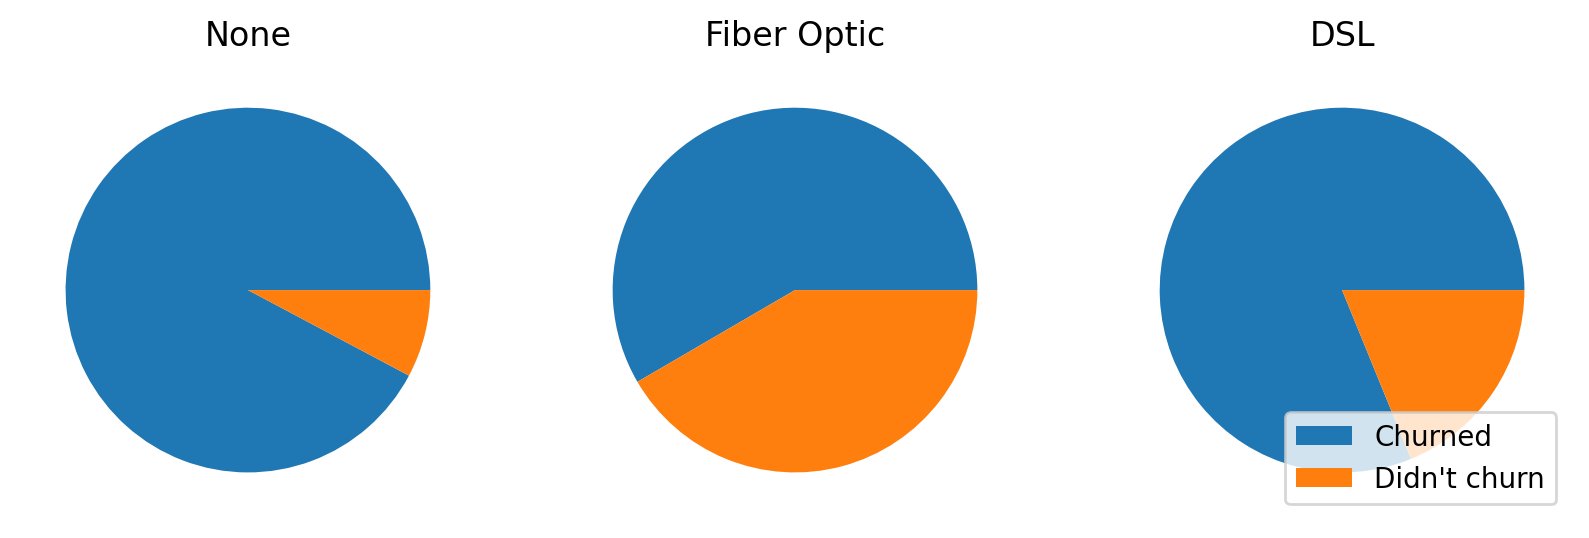

In [24]:
e.churn_by_ist(train)

## Dat Fiber Optic Churn Doe

![woof](https://i.pinimg.com/originals/6f/79/79/6f79795b600e39208a6e00414c838904.gif)



## Are technical issues driving customer churn?
#### While we do not a direct measurement of this, we can control for technical support to a similar effect

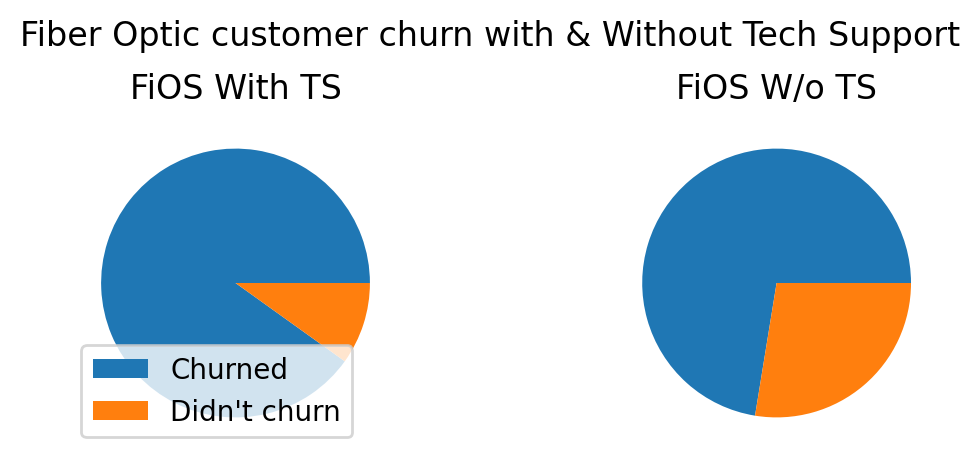

In [25]:
e.tech_support_vs_churn(train)

#### While this seems to hold true for Fiber Optic customers, I will now run a $\chi^2$ test to confirm it is true for all internet users



### Question: Is there a relationship between tech support and churn with internet customers

$H_0$: There is no significant relationship between churn and tech support for internet customers

$H_a$ There is a statistically significant relationship between churn and tech support for internet customers

We'll use a confidence interval of 95%, therefore
$\alpha = .05$

In [26]:
e.chi_squared(train)

$\chi^2:203.0269$

 $p:4.563810624441364e-46$

Since $p \lt \alpha$, we reject the null hypothesis and can assume a relationship between tech support and churn for internet customers

## Is gender a driver of churn?

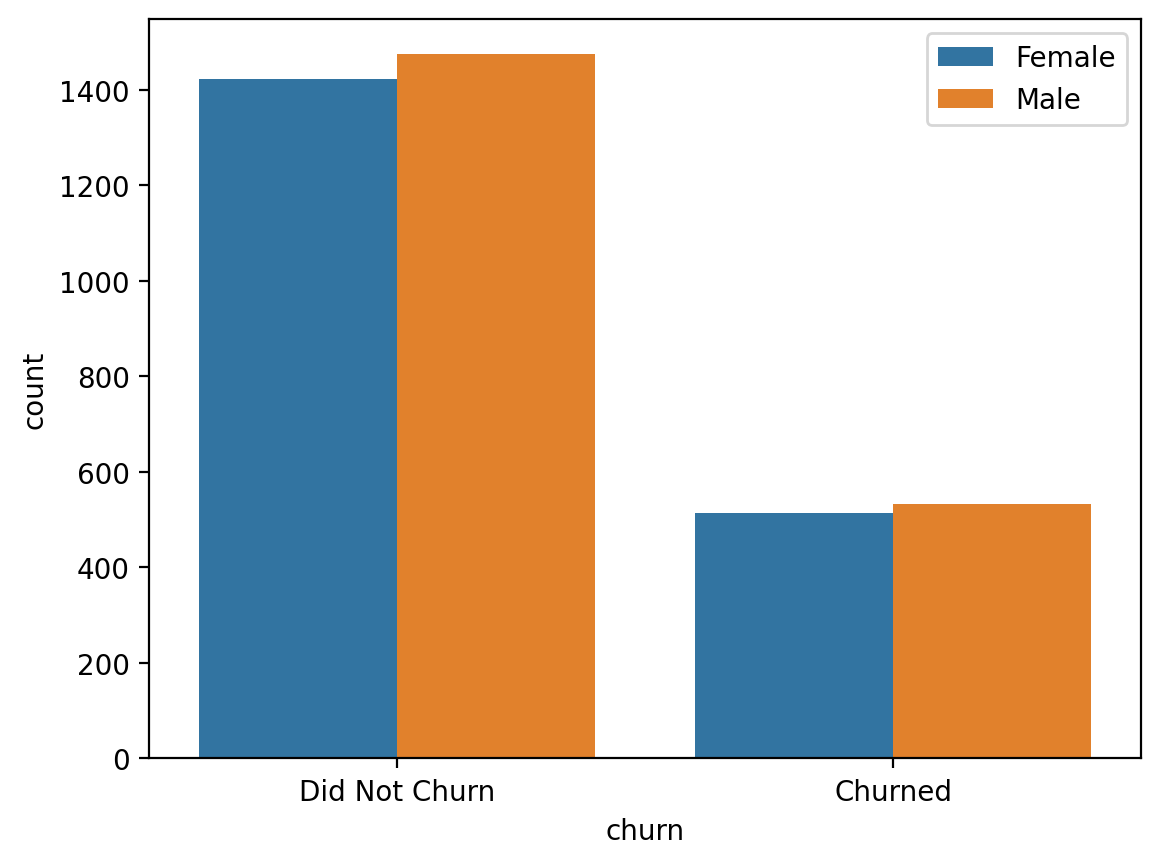

In [27]:
e.monthly_vs_total(train)

Because churn numbers are relatively normal across genders, it is unlikely that `is_male` will be an effective feature to model on.

### Enough about why customers leave... why do they stay?

## Do the number of plan add-ons affect customer tenure?

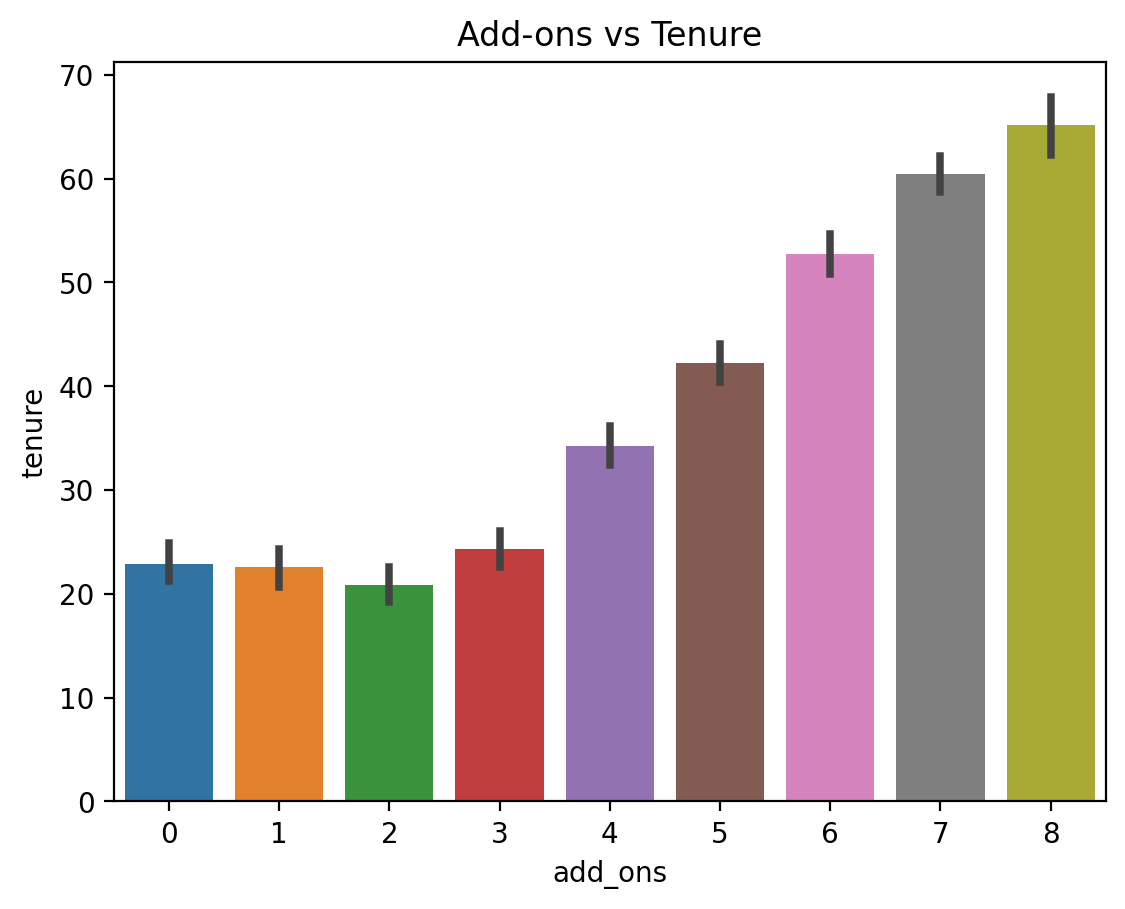

In [28]:
e.add_ons_vs_tenure(train)

It appears a greater number of add-ons is correlated to the number of add ons (customers with 2 add-ons seem to be an exception)

### Question: is there a linear correlation between tenure and monthly charges?

$H_0$: There is no correlation between the number of add-ons and a customer's tenure.

$H_a$: There is a linear correlation between the number of add-ons and a customer's tenure

Once again, we are using a 95% confidence interval, therefore $\alpha = .05$

In [29]:
e.pearson_test(train)


$ r = 0.491544910972547$

$p = 5.411825433605682e-239$

Because $r \gt 0 $ and $p \lt \alpha$, we reject the null hypothesis

## But what about specifics?

### Does a higher number of add-ons correlate to a lower rate of churn?

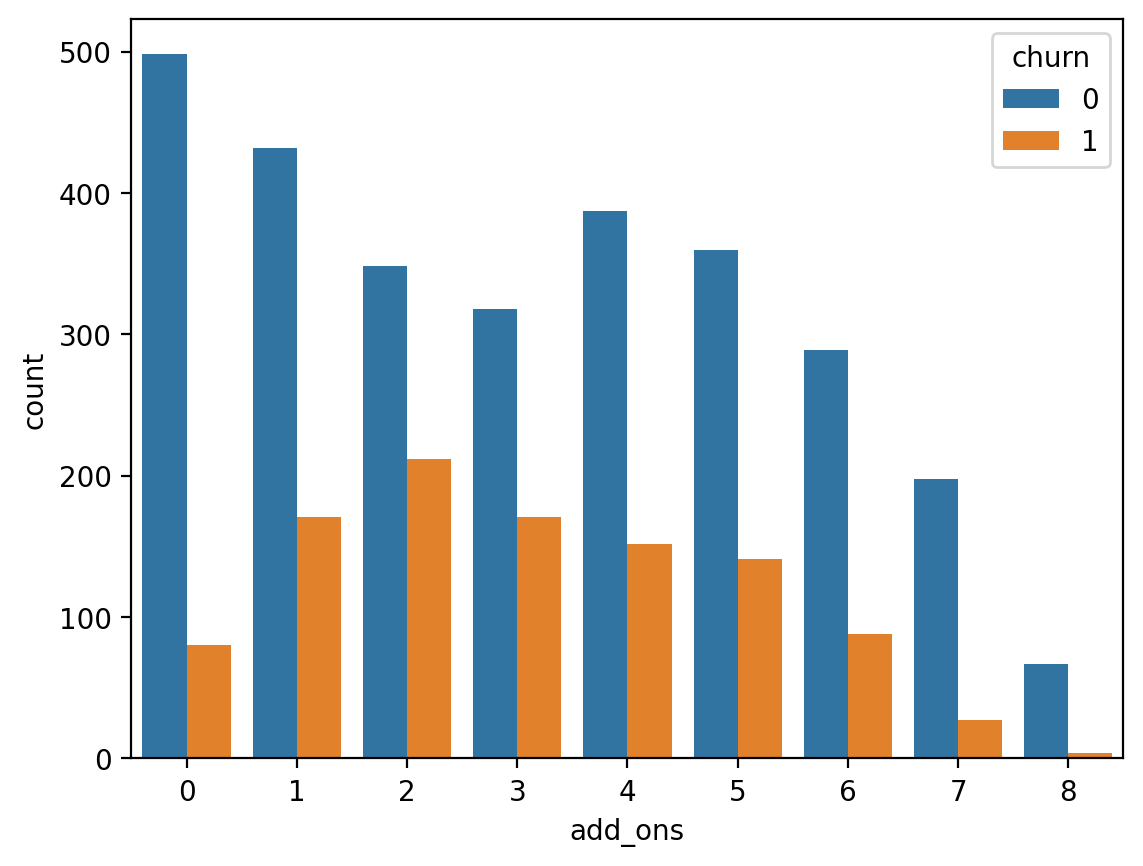

In [30]:
e.add_ons_w_churn(train)

Taken with the results of the $chi^2$ hypothesis test, there appears to be a correlation between the number of add-ons, longer customer tenure, and lower customer churn (where add-ons $\gt 2$)

## Exploration Summary:
- Fiber's in trouble
    - Fiber optic customers are more likely to churn than phone-only and DSL customers combined
    - This can be controlled for with technical support
    - Tech support also helps with DSL churn
- Customers like our add-ons
    - No. of add-ons was found to drive up tenure
    - Caveat: only true for No. add-ons $ \ne 2$
    - Higher No. of add-ons drives down churn (with above caveat in mind)
- Gender does not appear to be a driver of churn

### Features I'm modeling with
- add-ons, as there is a statistically significant relationship with tenure, and appears to be a relationship with churn based on statistical significance and visualizations
- tenure, as there appears to be a relationship between tenure and churn based on visualizations
- internet_service_type, as there is a significant relationship with churn based on the visualizations
- tech_support, as there is a statistically significant relationship between it and churn
### Features I'm not modeling with
- is_male, as there is little to no difference between men and women and the target
- monthly_charges, as preliminary investigation indicatesthis is directly related to the number of add-ons, which is accounted for.
- total charges, as it is directly related to monthly_charges and tenure, both of which are accounted for in modelled features
- specific add-on enrollment, as accounting for each individually would add unwanted complexity to the model and was not feasible in the time frame.
- senior_citizen, dependents, and partner as demographic trends were deemed outside the scope of this report.
- contract_type and payment_type, again, for model brevity


In [31]:
# Modeling

* I'm using precision as my evaluation metric
    * cheaper/easier to keep an existing customer than it is to find a new one
* 73% of users did not churn.

In [32]:
train_x, train_y, valid_x, valid_y, test_x, test_y = m.prep_for_modeling(train, validate, test)

In [33]:
m.get_baseline_precision(train,df.churn.mode())

0.0

baseline precision is 0, so there's room for improvement

## Decision Tree

In [34]:
m.get_decision_tree(train_x, train_y, valid_x, valid_y)

### Decision tree precision on `train`: 0.6687737041719343.        

 ### Decision tree precision on `validate`: 0.6568047337278107.

* decision tree outperforms the baseline

## Random Forest

In [35]:
m.get_rf(train_x, train_y, valid_x, valid_y)

### Random Forest precision on `train`: 0.6787330316742082.        

 ### Random Forest precision on `validate`: 0.6912280701754386.

* Random forest outperformed both the baseline and the decision tree

In [36]:
m.get_knn(train_x, train_y, valid_x, valid_y)

### K Nearest Neighbors precision on `train`: 0.7936170212765957.        

 ### K Nearest Neighbors precision on `validate`: 0.6372549019607843.

* KNN outperforms baseline, however it does not outperform Random Forest

Logistic Regression was not considered viable for these features, as it assumes too much independence therfore:

RandomForest is the winner!

## Run Random Forest on Test

In [37]:
m.rf_on_test(train_x,train_y,test_x,test_y)

### Random Forest precision on `validate`: 0.6867469879518072

## Modeling Summary
- Decision Tree, Random Forest, and KNN all performed significantly better than the baseline. 
- Of the three models, Random Forest performed the best
- Random Forest shows similar outperformance of baseline precision on test data set.

# Conclusions:
## Exploration:
- Churn impacts roughtly a quarter of current customer base
- Fiber optic customers churn the most
    - This appears to be mitigated with tech support
- More add-ons = more tenure
- customer's gender does not appear to have an effect on churn
## Modeling
**The final model significantly outperformed baseline in terms of precision**
## Recommendations:
- Bundle add-ons, as a greater number of add-ons appears to reduce customer churn
- Offer technical support for all internet users, or, more precisely, fiber optic users
## Next Steps:
- Investigate individual add-ons for correlation with customer churn
- Investigate demographics in order to better target customers for long-term growth.